<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/cosin%20dist/%20orth/TEST_cosian_dist_orth_best%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
'''
subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

** subjects  (train subject (ts) , new subject (ns) ):

1) Train subject i (ts[i] )
2) Train Subject i and Train Subject j (ts[i] , ts[j] )
3) Train subject and New subject  (ts , ns)
4) New subject i ( ns[i] )
5) New Subject i and New Subject j (ns[i] , ns[j] )

'''


'\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n** subjects  (train subject (ts) , new subject (ns) ):\n\n1) Train subject i (ts[i] )\n2) Train Subject i and Train Subject j (ts[i] , ts[j] )\n3) Train subject and New subject  (ts , ns)\n4) New subject i ( ns[i] )\n5) New Subject i and New Subject j (ns[i] , ns[j] )\n\n'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install mne

In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[61,40,10]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =160  # outer step len
sample_per_window = 160
window_len= 20
batch_size=64

#Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
#Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]


In [7]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime
import statistics

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


Automatically created module for IPython interactive environment


In [8]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S004/S004R01.edf...
EDF file detected


In [23]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sample_per_window - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = math.floor(len(subject_img_number_array_shuffled)* 0.75)
val_index = train_index + (train_index//5)

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
subject_img_number

59

In [85]:
a = [1,2,3,4,5,6]
b= [4,6,8]
c= list(set(a)-set(b))
c

[1, 2, 3, 5]

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        

        # Orthogonal Channel
        DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        DataChannelsOrt[e][2]=DataChannelsNormal[e][2]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[e][1].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag

        e = e+1
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, sample_per_window), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[r][i][0+j*OuterSampleShift + z*InnerSampleShift:sample_per_window+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
# Construct Data Generator

GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

Epoch 1/50
1235/1235 [==============================] - 34s 28ms/step - loss: 2.9946 - acc: 0.1916 - val_loss: 1.8984 - val_acc: 0.4430
Epoch 2/50
1235/1235 [==============================] - 32s 26ms/step - loss: 1.5926 - acc: 0.5047 - val_loss: 0.9689 - val_acc: 0.7037
Epoch 3/50
1235/1235 [==============================] - 32s 26ms/step - loss: 0.8609 - acc: 0.7191 - val_loss: 0.6034 - val_acc: 0.7986
Epoch 4/50
1235/1235 [==============================] - 33s 26ms/step - loss: 0.5275 - acc: 0.8227 - val_loss: 0.3816 - val_acc: 0.8719
Epoch 5/50
1235/1235 [==============================] - 33s 27ms/step - loss: 0.3440 - acc: 0.8838 - val_loss: 0.1940 - val_acc: 0.9345
Epoch 6/50
1235/1235 [==============================] - 32s 26ms/step - loss: 0.2332 - acc: 0.9193 - val_loss: 0.1363 - val_acc: 0.9550
Epoch 7/50
1235/1235 [==============================] - 32s 26ms/step - loss: 0.1637 - acc: 0.9438 - val_loss: 0.0833 - val_acc: 0.9713
Epoch 8/50
1235/1235 [==========================

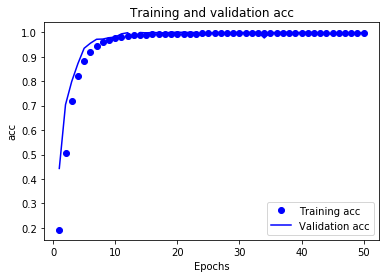

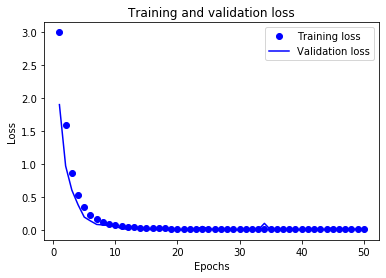

In [19]:


#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape = (window_len,160,ch_number) ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(subject_numberT, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

#################################################################################################
filepath = '/content/drive/My Drive/mymodels/bestmodel_point.h5'
#earlystopping_callback = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0,patience=10,mode='auto', restore_best_weights=True)
ModelCheckpoint_callbacks = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1)
# Train the Model
history = model.fit_generator(epochs =50,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              callbacks=[ModelCheckpoint_callbacks],
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

In [0]:
#model.save('/content/drive/My Drive/mymodels/finalmodel_orth_Oz_T7_C3.h5')

In [27]:
model = load_model('/content/drive/My Drive/mymodels/bestmodel_point.h5')
model.summary()
model.pop()
model.pop()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 160, 128)      3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 80, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 78, 256)        295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 39, 256)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 37, 512)        1180160   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 18, 512)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


     TrainResult ([loss , acc])= [0.00010601813004244913, 1.0]
ValidationResult ([loss , acc])= [0.00021139885681026248, 1.0]
      TestResult ([loss , acc])= [0.0003442101747798707, 1.0]


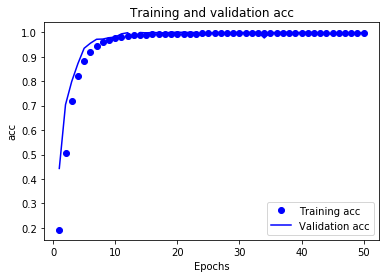

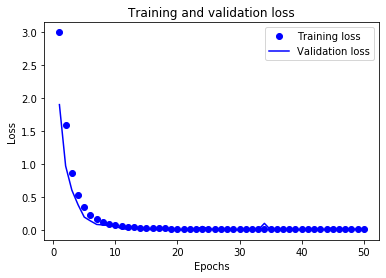

In [21]:
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


total_vector=[]
subject_img_idx_array = np.arange(subject_img_number)

for i in range(109):
  Si_vectors = subject_Predict_generator(len(subject_img_idx_array), model, [i], subject_img_idx_array)
  total_vector.append(Si_vectors)

In [30]:
import h5py
hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_160_spw.h5', 'w')
hf.create_dataset('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors', data=total_vector)
hf.close()
hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_160_spw.h5', 'r')
vec = hf.get('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors')
vec


<HDF5 dataset "dataset_total_vectors": shape (109, 59, 1024), type "<f4">

In [0]:
### verification with middle of samples

def VerifySubject(threshold, s1, smp1, s2, smp2):
  list_d =[]

  for i in range(len(smp1)):
    #print(s1 ,vec1[i] )
    d= distance.cosine(vec[s1][smp1[i]], vec[s2][smp2[i]])
    list_d.append(d)
  midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [0]:
from shapely.geometry import LineString



In [0]:
### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  tryatr="try4"
  threshold = 0
  pair_number = 2000
  sample_img_num = 25
  Batch_size = 25
  ITER = pair_number //2


  path = "/content/drive/My Drive/Orth_cosian/"+tryatr+" best point model- cosian dist_true ORTH new model" +str(sample_img_num)+"sample num_"+str(pair_number)+"pair_"+ "ouer shift" + str(outer_sample_shift)

  try:
      os.mkdir(path)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s " % path)



  
  ## CSV file name 
  csvFileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  list_threshold = []
  list_TP = []
  list_TN = []
  list_FP = []
  list_FN = []
  list_FRR = []
  list_FAR = []
  list_EER = []
  list_Correct_Verifi_Percentage = []
  list_threshold_result =[]


  for j in range(1,15):

      threshold =0.225+ (j*0.01)
      threshold = round(threshold,4)
      #threshold = j
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[:sample_img_num]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[sample_img_num : sample_img_num *2]

          # Genuine verify
          result1 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[:sample_img_num]

          # Impostor vrify
          result2 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(j,') ' ,threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )
  
  x= np.array(list_FRR )
  #f= np.array(list_FRR )
  g= np.array(list_FAR )
  x1 = np.array([0,0.08])
  g1 = np.array([0,0.08])

  plt.figure(figsize=(10,10))

  i= 0
  # zip joins x and y coordinates in pairs
  for a,b in zip(x, g):
      #thr_round = list_threshold[i]
      label = str(i)
      i= i+1

      plt.annotate(label, (a,b))


  plt.plot(x, g)
  plt.plot(x1, g1)

  first_line = LineString(np.column_stack((x, g)))
  second_line = LineString(np.column_stack((x1, g1)))
  intersection = first_line.intersection(second_line)
  plt.plot(intersection,intersection, 'o')
  print(intersection)
 
 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()

  plt.savefig(png_completeName) 
  #bob.measure.plot.det(list_FRR,list_FAR)
  #%matplotlib qt

  print("###" +"S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")")

  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_FAR[j], list_FRR[j] , list_EER[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])



In [3]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

NameError: ignored

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_20pair_ouer shift160 failed
0.255 . 
 95.0 % 
 true_result: 19 false_result: 1 
 TP: 9 FN: 1 FRR: 0.1 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.05 

0.26 . 
 95.0 % 
 true_result: 19 false_result: 1 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 9 FP: 1 FAR: 0.1 
 EER: 0.05 

0.265 . 
 100.0 % 
 true_result: 20 false_result: 0 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.0 

0.27 . 
 100.0 % 
 true_result: 20 false_result: 0 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.0 

0.275 . 
 100.0 % 
 true_result: 20 false_result: 0 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.0 

0.28 . 
 95.0 % 
 true_result: 19 false_result: 1 
 TP: 9 FN: 1 FRR: 0.1 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.05 

0.285 . 
 100.0 % 
 true_result: 20 false_result: 0 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 10 FP: 0 FAR: 0.0 
 EER: 0.0 

0.29 . 
 100.0 % 
 true_result: 20 false_result: 0 
 TP: 1

No handles with labels found to put in legend.


0.42 . 
 95.0 % 
 true_result: 19 false_result: 1 
 TP: 10 FN: 0 FRR: 0.0 
 TN: 9 FP: 1 FAR: 0.1 
 EER: 0.05 

MULTIPOINT (0 0, 0.05 0.05)
###S1(0-89)_S2(0-89)


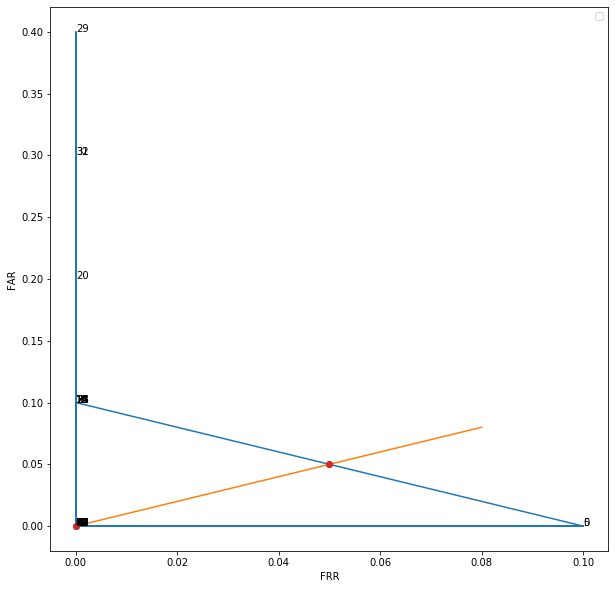

In [40]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Successfully created the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_2000pair_ouer shift160 
0.252 . 
 96.15 % 
 true_result: 1923 false_result: 77 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0385 

0.254 . 
 96.5 % 
 true_result: 1930 false_result: 70 
 TP: 952 FN: 48 FRR: 0.048 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.035 

0.256 . 
 95.55 % 
 true_result: 1911 false_result: 89 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0445 

0.258 . 
 95.55 % 
 true_result: 1911 false_result: 89 
 TP: 939 FN: 61 FRR: 0.061 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.0445 

0.26 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.033 

0.262 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 960 FN: 40 FRR: 0.04 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.033 

0.264 . 
 95.75 % 
 true_result: 1915 false_result: 85 
 TP: 950 FN: 50 FRR: 0.05 
 TN: 965 F

No handles with labels found to put in legend.


0.298 . 
 97.45 % 
 true_result: 1949 false_result: 51 
 TP: 984 FN: 16 FRR: 0.016 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.025500000000000002 

MULTIPOINT (0.02525 0.02525, 0.02933333333333333 0.02933333333333333, 0.03 0.03, 0.0336 0.0336)
###S1(0-89)_S2(0-89)


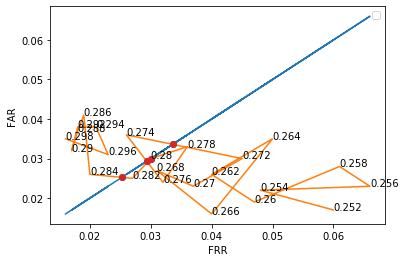

In [58]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Successfully created the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 
0.252 . 
 95.96666666666667 % 
 true_result: 2879 false_result: 121 
 TP: 1414 FN: 86 FRR: 0.05733333333333333 
 TN: 1465 FP: 35 FAR: 0.023333333333333334 
 EER: 0.04033333333333333 

0.254 . 
 95.96666666666667 % 
 true_result: 2879 false_result: 121 
 TP: 1416 FN: 84 FRR: 0.056 
 TN: 1463 FP: 37 FAR: 0.024666666666666667 
 EER: 0.04033333333333333 

0.256 . 
 96.16666666666667 % 
 true_result: 2885 false_result: 115 
 TP: 1424 FN: 76 FRR: 0.050666666666666665 
 TN: 1461 FP: 39 FAR: 0.026 
 EER: 0.03833333333333333 

0.258 . 
 96.93333333333334 % 
 true_result: 2908 false_result: 92 
 TP: 1445 FN: 55 FRR: 0.03666666666666667 
 TN: 1463 FP: 37 FAR: 0.024666666666666667 
 EER: 0.03066666666666667 

0.26 . 
 96.6 % 
 true_result: 2898 false_result: 102 
 TP: 1431 FN: 69 FRR: 0.046 
 TN: 1467 FP: 33 FAR: 0.022 
 EER: 0.034 

0.262 . 
 96

No handles with labels found to put in legend.


0.298 . 
 97.5 % 
 true_result: 2925 false_result: 75 
 TP: 1478 FN: 22 FRR: 0.014666666666666666 
 TN: 1447 FP: 53 FAR: 0.035333333333333335 
 EER: 0.025 

MULTIPOINT (0.02733333333333333 0.02733333333333333, 0.02745833333333333 0.02745833333333333, 0.02777777777777778 0.02777777777777778, 0.03034782608695652 0.03034782608695652, 0.03053333333333333 0.03053333333333333)
###S1(0-89)_S2(0-89)


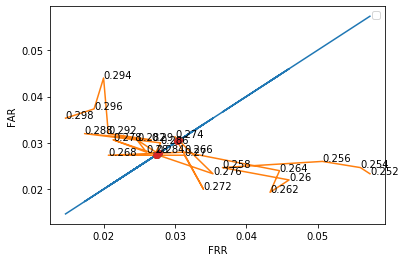

In [61]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 failed
0.252 . 
 96.1 % 
 true_result: 2883 false_result: 117 
 TP: 1420 FN: 80 FRR: 0.05333333333333334 
 TN: 1463 FP: 37 FAR: 0.024666666666666667 
 EER: 0.039 

0.254 . 
 96.83333333333333 % 
 true_result: 2905 false_result: 95 
 TP: 1429 FN: 71 FRR: 0.04733333333333333 
 TN: 1476 FP: 24 FAR: 0.016 
 EER: 0.03166666666666666 

0.256 . 
 96.8 % 
 true_result: 2904 false_result: 96 
 TP: 1437 FN: 63 FRR: 0.042 
 TN: 1467 FP: 33 FAR: 0.022 
 EER: 0.032 

0.258 . 
 96.9 % 
 true_result: 2907 false_result: 93 
 TP: 1443 FN: 57 FRR: 0.038 
 TN: 1464 FP: 36 FAR: 0.024 
 EER: 0.031 

0.26 . 
 97.16666666666667 % 
 true_result: 2915 false_result: 85 
 TP: 1446 FN: 54 FRR: 0.036 
 TN: 1469 FP: 31 FAR: 0.020666666666666667 
 EER: 0.028333333333333332 

0.262 . 
 96.93333333333334 % 
 true_result: 2908 false_result: 92 
 TP: 1442 FN: 58 FRR: 0.038666666

No handles with labels found to put in legend.


0.298 . 
 97.4 % 
 true_result: 2922 false_result: 78 
 TP: 1480 FN: 20 FRR: 0.013333333333333334 
 TN: 1442 FP: 58 FAR: 0.03866666666666667 
 EER: 0.026000000000000002 

MULTIPOINT (0.02701449275362319 0.02701449275362319, 0.0287536231884058 0.0287536231884058, 0.03015686274509804 0.03015686274509804)
###S1(0-89)_S2(90-108)


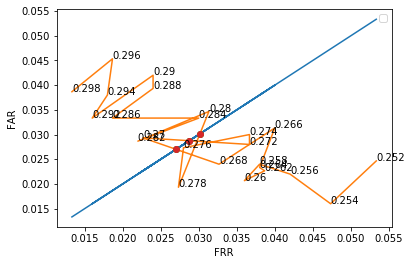

In [62]:
#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 failed
0.252 . 
 89.33333333333333 % 
 true_result: 2680 false_result: 320 
 TP: 1220 FN: 280 FRR: 0.18666666666666668 
 TN: 1460 FP: 40 FAR: 0.02666666666666667 
 EER: 0.10666666666666667 

0.254 . 
 89.8 % 
 true_result: 2694 false_result: 306 
 TP: 1221 FN: 279 FRR: 0.186 
 TN: 1473 FP: 27 FAR: 0.018 
 EER: 0.102 

0.256 . 
 90.9 % 
 true_result: 2727 false_result: 273 
 TP: 1263 FN: 237 FRR: 0.158 
 TN: 1464 FP: 36 FAR: 0.024 
 EER: 0.091 

0.258 . 
 91.53333333333333 % 
 true_result: 2746 false_result: 254 
 TP: 1273 FN: 227 FRR: 0.15133333333333332 
 TN: 1473 FP: 27 FAR: 0.018 
 EER: 0.08466666666666665 

0.26 . 
 91.6 % 
 true_result: 2748 false_result: 252 
 TP: 1272 FN: 228 FRR: 0.152 
 TN: 1476 FP: 24 FAR: 0.016 
 EER: 0.08399999999999999 

0.262 . 
 91.86666666666666 % 
 true_result: 2756 false_result: 244 
 TP: 1287 FN: 213 FRR: 0.1

No handles with labels found to put in legend.


0.308 . 
 94.5 % 
 true_result: 2835 false_result: 165 
 TP: 1437 FN: 63 FRR: 0.042 
 TN: 1398 FP: 102 FAR: 0.068 
 EER: 0.05500000000000001 

MULTIPOINT (0.04748717948717949 0.04748717948717949, 0.04865116279069767 0.04865116279069767, 0.05302564102564103 0.05302564102564103)
###S1(90-108)_S2(0-89)


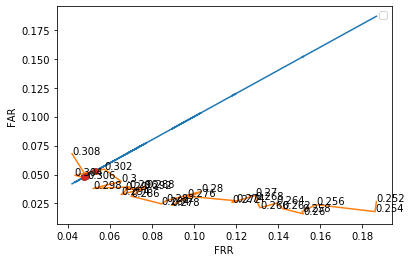

In [65]:
#3. new subject , new subject

counter_true_false_result(90,108, 0,89)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 failed
0.252 . 
 90.63333333333334 % 
 true_result: 2719 false_result: 281 
 TP: 1235 FN: 265 FRR: 0.17666666666666667 
 TN: 1484 FP: 16 FAR: 0.010666666666666666 
 EER: 0.09366666666666666 

0.254 . 
 91.26666666666667 % 
 true_result: 2738 false_result: 262 
 TP: 1246 FN: 254 FRR: 0.16933333333333334 
 TN: 1492 FP: 8 FAR: 0.005333333333333333 
 EER: 0.08733333333333333 

0.256 . 
 91.76666666666667 % 
 true_result: 2753 false_result: 247 
 TP: 1272 FN: 228 FRR: 0.152 
 TN: 1481 FP: 19 FAR: 0.012666666666666666 
 EER: 0.08233333333333333 

0.258 . 
 91.96666666666667 % 
 true_result: 2759 false_result: 241 
 TP: 1279 FN: 221 FRR: 0.14733333333333334 
 TN: 1480 FP: 20 FAR: 0.013333333333333334 
 EER: 0.08033333333333334 

0.26 . 
 91.96666666666667 % 
 true_result: 2759 false_result: 241 
 TP: 1283 FN: 217 FRR: 0.14466666666666667 
 TN: 1476 FP

No handles with labels found to put in legend.


0.308 . 
 95.5 % 
 true_result: 2865 false_result: 135 
 TP: 1428 FN: 72 FRR: 0.048 
 TN: 1437 FP: 63 FAR: 0.042 
 EER: 0.045 

MULTIPOINT (0.04333333333333333 0.04333333333333333, 0.04547619047619048 0.04547619047619048)
###S1(90-108)_S2(90-108)


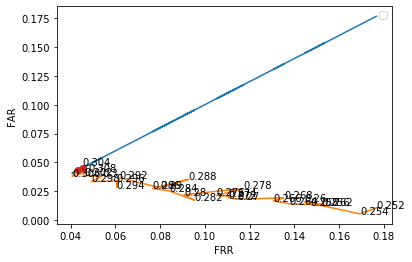

In [66]:
#4. new subject , new subject

counter_true_false_result(90,108, 90,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 failed
0.252 . 
 91.2 % 
 true_result: 2736 false_result: 264 
 TP: 1256 FN: 244 FRR: 0.16266666666666665 
 TN: 1480 FP: 20 FAR: 0.013333333333333334 
 EER: 0.088 

0.254 . 
 90.9 % 
 true_result: 2727 false_result: 273 
 TP: 1241 FN: 259 FRR: 0.17266666666666666 
 TN: 1486 FP: 14 FAR: 0.009333333333333334 
 EER: 0.091 

0.256 . 
 90.9 % 
 true_result: 2727 false_result: 273 
 TP: 1246 FN: 254 FRR: 0.16933333333333334 
 TN: 1481 FP: 19 FAR: 0.012666666666666666 
 EER: 0.091 

0.258 . 
 92.03333333333333 % 
 true_result: 2761 false_result: 239 
 TP: 1278 FN: 222 FRR: 0.148 
 TN: 1483 FP: 17 FAR: 0.011333333333333334 
 EER: 0.07966666666666666 

0.26 . 
 92.1 % 
 true_result: 2763 false_result: 237 
 TP: 1287 FN: 213 FRR: 0.142 
 TN: 1476 FP: 24 FAR: 0.016 
 EER: 0.07899999999999999 

0.262 . 
 92.06666666666666 % 
 true_result: 2762 false_result

No handles with labels found to put in legend.


0.318 . 
 96.1 % 
 true_result: 2883 false_result: 117 
 TP: 1453 FN: 47 FRR: 0.03133333333333333 
 TN: 1430 FP: 70 FAR: 0.04666666666666667 
 EER: 0.039 

POINT (0.04661904761904762 0.04661904761904762)
###S1(90-108)_S2(90-108)


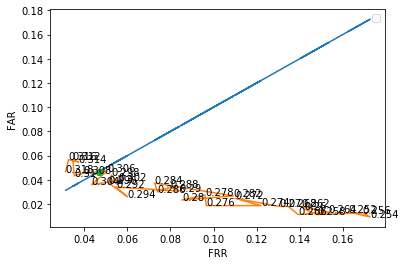

In [68]:
#4. new subject , new subject

counter_true_false_result(90,108, 90,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model10sample num_3000pair_ouer shift160 failed
0.252 . 
 95.96666666666667 % 
 true_result: 2879 false_result: 121 
 TP: 1409 FN: 91 FRR: 0.06066666666666667 
 TN: 1470 FP: 30 FAR: 0.02 
 EER: 0.04033333333333333 

0.254 . 
 95.33333333333333 % 
 true_result: 2860 false_result: 140 
 TP: 1383 FN: 117 FRR: 0.078 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.04666666666666667 

0.256 . 
 95.9 % 
 true_result: 2877 false_result: 123 
 TP: 1405 FN: 95 FRR: 0.06333333333333334 
 TN: 1472 FP: 28 FAR: 0.018666666666666668 
 EER: 0.041 

0.258 . 
 95.26666666666667 % 
 true_result: 2858 false_result: 142 
 TP: 1393 FN: 107 FRR: 0.07133333333333333 
 TN: 1465 FP: 35 FAR: 0.023333333333333334 
 EER: 0.04733333333333333 

0.26 . 
 95.96666666666667 % 
 true_result: 2879 false_result: 121 
 TP: 1408 FN: 92 FRR: 0.06133333333333333 
 TN: 1471 FP: 29 FAR: 0.019333333333333334 
 EER: 0.04033

No handles with labels found to put in legend.


0.318 . 
 96.53333333333333 % 
 true_result: 2896 false_result: 104 
 TP: 1484 FN: 16 FRR: 0.010666666666666666 
 TN: 1412 FP: 88 FAR: 0.058666666666666666 
 EER: 0.034666666666666665 

POINT (0.03357333333333333 0.03357333333333333)
###S1(0-108)_S2(0-108)


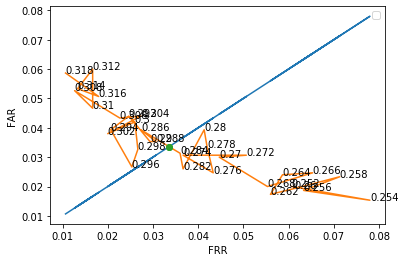

In [69]:
#5. all subject , all subject

counter_true_false_result(0,108, 0,108)

Successfully created the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_3000pair_ouer shift160 
0.255 . 
 96.53333333333333 % 
 true_result: 2896 false_result: 104 
 TP: 1416 FN: 84 FRR: 0.056 
 TN: 1480 FP: 20 FAR: 0.013333333333333334 
 EER: 0.034666666666666665 

0.26 . 
 96.4 % 
 true_result: 2892 false_result: 108 
 TP: 1423 FN: 77 FRR: 0.051333333333333335 
 TN: 1469 FP: 31 FAR: 0.020666666666666667 
 EER: 0.036000000000000004 

0.265 . 
 96.66666666666667 % 
 true_result: 2900 false_result: 100 
 TP: 1432 FN: 68 FRR: 0.04533333333333334 
 TN: 1468 FP: 32 FAR: 0.021333333333333333 
 EER: 0.03333333333333333 

0.27 . 
 96.8 % 
 true_result: 2904 false_result: 96 
 TP: 1436 FN: 64 FRR: 0.042666666666666665 
 TN: 1468 FP: 32 FAR: 0.021333333333333333 
 EER: 0.032 

0.275 . 
 96.83333333333333 % 
 true_result: 2905 false_result: 95 
 TP: 1439 FN: 61 FRR: 0.04066666666666666 
 TN: 1466 FP: 34 FAR: 0.02266666666666667 
 EER: 0.0

No handles with labels found to put in legend.


0.42 . 
 92.73333333333333 % 
 true_result: 2782 false_result: 218 
 TP: 1500 FN: 0 FRR: 0.0 
 TN: 1282 FP: 218 FAR: 0.14533333333333334 
 EER: 0.07266666666666667 

POINT (0.0241025641025641 0.0241025641025641)
###S1(0-89)_S2(0-89)


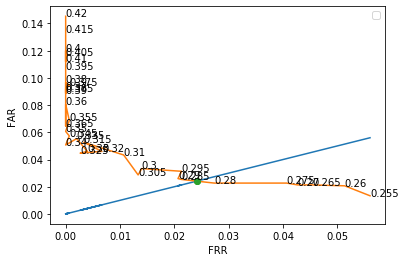

In [71]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_3000pair_ouer shift160 failed
0.255 . 
 87.9 % 
 true_result: 2637 false_result: 363 
 TP: 1156 FN: 344 FRR: 0.22933333333333333 
 TN: 1481 FP: 19 FAR: 0.012666666666666666 
 EER: 0.121 

0.26 . 
 90.03333333333333 % 
 true_result: 2701 false_result: 299 
 TP: 1223 FN: 277 FRR: 0.18466666666666667 
 TN: 1478 FP: 22 FAR: 0.014666666666666666 
 EER: 0.09966666666666667 

0.265 . 
 91.03333333333333 % 
 true_result: 2731 false_result: 269 
 TP: 1255 FN: 245 FRR: 0.16333333333333333 
 TN: 1476 FP: 24 FAR: 0.016 
 EER: 0.08966666666666667 

0.27 . 
 91.13333333333334 % 
 true_result: 2734 false_result: 266 
 TP: 1269 FN: 231 FRR: 0.154 
 TN: 1465 FP: 35 FAR: 0.023333333333333334 
 EER: 0.08866666666666667 

0.275 . 
 91.76666666666667 % 
 true_result: 2753 false_result: 247 
 TP: 1276 FN: 224 FRR: 0.14933333333333335 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.08

No handles with labels found to put in legend.


0.42 . 
 92.13333333333334 % 
 true_result: 2764 false_result: 236 
 TP: 1500 FN: 0 FRR: 0.0 
 TN: 1264 FP: 236 FAR: 0.15733333333333333 
 EER: 0.07866666666666666 

POINT (0.03694444444444445 0.03694444444444445)
###S1(90-108)_S2(0-89)


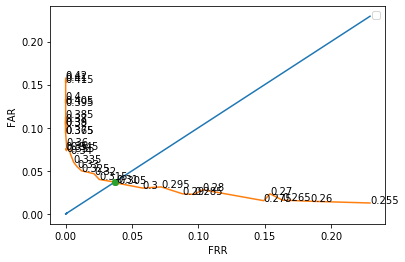

In [73]:
#3. train subject , train subject
counter_true_false_result(90,108,0,89) 

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_3000pair_ouer shift160 failed
0.255 . 
 89.43333333333334 % 
 true_result: 2683 false_result: 317 
 TP: 1199 FN: 301 FRR: 0.20066666666666666 
 TN: 1484 FP: 16 FAR: 0.010666666666666666 
 EER: 0.10566666666666666 

0.26 . 
 90.73333333333333 % 
 true_result: 2722 false_result: 278 
 TP: 1236 FN: 264 FRR: 0.176 
 TN: 1486 FP: 14 FAR: 0.009333333333333334 
 EER: 0.09266666666666666 

0.265 . 
 91.53333333333333 % 
 true_result: 2746 false_result: 254 
 TP: 1266 FN: 234 FRR: 0.156 
 TN: 1480 FP: 20 FAR: 0.013333333333333334 
 EER: 0.08466666666666667 

0.27 . 
 92.23333333333333 % 
 true_result: 2767 false_result: 233 
 TP: 1292 FN: 208 FRR: 0.13866666666666666 
 TN: 1475 FP: 25 FAR: 0.016666666666666666 
 EER: 0.07766666666666666 

0.275 . 
 92.9 % 
 true_result: 2787 false_result: 213 
 TP: 1302 FN: 198 FRR: 0.132 
 TN: 1485 FP: 15 FAR: 0.01 
 EER: 0.07100000000000001

No handles with labels found to put in legend.


0.42 . 
 92.0 % 
 true_result: 2760 false_result: 240 
 TP: 1500 FN: 0 FRR: 0.0 
 TN: 1260 FP: 240 FAR: 0.16 
 EER: 0.08 

MULTIPOINT (0.02813333333333333 0.02813333333333333, 0.0296 0.0296, 0.03688888888888889 0.03688888888888889)
###S1(90-108)_S2(90-108)


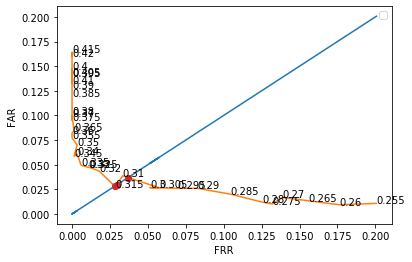

In [74]:
#4. train subject , train subject
counter_true_false_result(90,108,90,108) 

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_3000pair_ouer shift160 failed
0.255 . 
 94.46666666666667 % 
 true_result: 2834 false_result: 166 
 TP: 1369 FN: 131 FRR: 0.08733333333333333 
 TN: 1465 FP: 35 FAR: 0.023333333333333334 
 EER: 0.05533333333333333 

0.26 . 
 95.06666666666666 % 
 true_result: 2852 false_result: 148 
 TP: 1389 FN: 111 FRR: 0.074 
 TN: 1463 FP: 37 FAR: 0.024666666666666667 
 EER: 0.04933333333333333 

0.265 . 
 95.96666666666667 % 
 true_result: 2879 false_result: 121 
 TP: 1402 FN: 98 FRR: 0.06533333333333333 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.04033333333333333 

0.27 . 
 95.86666666666666 % 
 true_result: 2876 false_result: 124 
 TP: 1411 FN: 89 FRR: 0.059333333333333335 
 TN: 1465 FP: 35 FAR: 0.023333333333333334 
 EER: 0.04133333333333333 

0.275 . 
 96.3 % 
 true_result: 2889 false_result: 111 
 TP: 1422 FN: 78 FRR: 0.052 
 TN: 1467 FP: 33 FAR: 0.022 
 EER: 0.037 

No handles with labels found to put in legend.


0.42 . 
 91.86666666666666 % 
 true_result: 2756 false_result: 244 
 TP: 1500 FN: 0 FRR: 0.0 
 TN: 1256 FP: 244 FAR: 0.16266666666666665 
 EER: 0.08133333333333333 

POINT (0.02410526315789474 0.02410526315789474)
###S1(0-108)_S2(0-108)


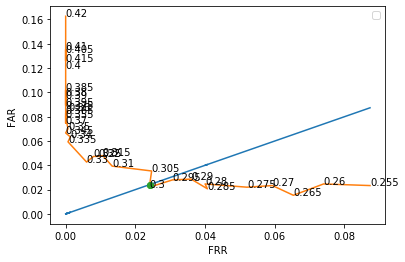

In [75]:
#4. train subject , train subject
counter_true_false_result(0,108,0,108) 

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_200pair_ouer shift160 failed
0.255 . 
 96.0 % 
 true_result: 192 false_result: 8 
 TP: 96 FN: 4 FRR: 0.04 
 TN: 96 FP: 4 FAR: 0.04 
 EER: 0.04 

0.26 . 
 95.5 % 
 true_result: 191 false_result: 9 
 TP: 93 FN: 7 FRR: 0.07 
 TN: 98 FP: 2 FAR: 0.02 
 EER: 0.045000000000000005 

0.265 . 
 98.0 % 
 true_result: 196 false_result: 4 
 TP: 97 FN: 3 FRR: 0.03 
 TN: 99 FP: 1 FAR: 0.01 
 EER: 0.02 

0.27 . 
 97.5 % 
 true_result: 195 false_result: 5 
 TP: 96 FN: 4 FRR: 0.04 
 TN: 99 FP: 1 FAR: 0.01 
 EER: 0.025 

0.275 . 
 98.5 % 
 true_result: 197 false_result: 3 
 TP: 98 FN: 2 FRR: 0.02 
 TN: 99 FP: 1 FAR: 0.01 
 EER: 0.015 

0.28 . 
 96.0 % 
 true_result: 192 false_result: 8 
 TP: 97 FN: 3 FRR: 0.03 
 TN: 95 FP: 5 FAR: 0.05 
 EER: 0.04 

0.285 . 
 97.5 % 
 true_result: 195 false_result: 5 
 TP: 97 FN: 3 FRR: 0.03 
 TN: 98 FP: 2 FAR: 0.02 
 EER: 0.025 

0.29 . 
 98.0 % 
 true

No handles with labels found to put in legend.


0.42 . 
 91.0 % 
 true_result: 182 false_result: 18 
 TP: 100 FN: 0 FRR: 0.0 
 TN: 82 FP: 18 FAR: 0.18 
 EER: 0.09 

MULTIPOINT (0.02 0.02, 0.02333333333333333 0.02333333333333333, 0.03 0.03, 0.04 0.04)
###S1(0-89)_S2(0-89)


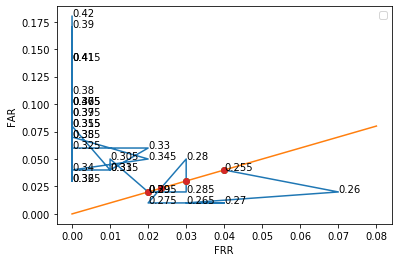

In [79]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 96.4 % 
 true_result: 1928 false_result: 72 
 TP: 950 FN: 50 FRR: 0.05 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.036000000000000004 

0.26 . 
 96.85 % 
 true_result: 1937 false_result: 63 
 TP: 948 FN: 52 FRR: 0.052 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0315 

0.265 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 956 FN: 44 FRR: 0.044 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0305 

0.27 . 
 96.45 % 
 true_result: 1929 false_result: 71 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.035500000000000004 

0.275 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.033 

0.28 . 
 96.65 % 
 true_result: 1933 false_result: 67 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0335 

0.285 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 977 FN

No handles with labels found to put in legend.


0.42 . 
 93.0 % 
 true_result: 1860 false_result: 140 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 860 FP: 140 FAR: 0.14 
 EER: 0.07 

POINT (0.023 0.023)
###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 96.65 % 
 true_result: 1933 false_result: 67 
 TP: 943 FN: 57 FRR: 0.057 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.0335 

0.26 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.03 

0.265 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 957 FN: 43 FRR: 0.043 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.0305 

0.27 . 
 97.25 % 
 true_result: 1945 false_result: 55 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0275 

0.275 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.024 

0.28 . 
 96.8 % 
 true_result: 1936 false_result: 64 
 TP: 

No handles with labels found to put in legend.


0.42 . 
 92.65 % 
 true_result: 1853 false_result: 147 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 853 FP: 147 FAR: 0.147 
 EER: 0.0735 

MULTIPOINT (0.029 0.029, 0.032 0.032)
###S1(0-89)_S2(90-107)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 88.6 % 
 true_result: 1772 false_result: 228 
 TP: 790 FN: 210 FRR: 0.21 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.11399999999999999 

0.26 . 
 90.5 % 
 true_result: 1810 false_result: 190 
 TP: 828 FN: 172 FRR: 0.172 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.09499999999999999 

0.265 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 855 FN: 145 FRR: 0.145 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.08049999999999999 

0.27 . 
 92.55 % 
 true_result: 1851 false_result: 149 
 TP: 873 FN: 127 FRR: 0.127 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.0745 

0.275 . 
 92.35 % 
 true_result: 1847 false_result: 153 
 TP: 865 FN: 135 FRR: 0.135 
 TN: 982 FP: 18 FAR: 0.018

No handles with labels found to put in legend.


0.42 . 
 92.05 % 
 true_result: 1841 false_result: 159 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 841 FP: 159 FAR: 0.159 
 EER: 0.0795 

POINT (0.03458823529411764 0.03458823529411765)
###S1(90-107)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 89.85 % 
 true_result: 1797 false_result: 203 
 TP: 806 FN: 194 FRR: 0.194 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.1015 

0.26 . 
 90.5 % 
 true_result: 1810 false_result: 190 
 TP: 819 FN: 181 FRR: 0.181 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.095 

0.265 . 
 92.75 % 
 true_result: 1855 false_result: 145 
 TP: 866 FN: 134 FRR: 0.134 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.07250000000000001 

0.27 . 
 92.25 % 
 true_result: 1845 false_result: 155 
 TP: 859 FN: 141 FRR: 0.141 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0775 

0.275 . 
 92.85 % 
 true_result: 1857 false_result: 143 
 TP: 876 FN: 124 FRR: 0.124 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0715 



No handles with labels found to put in legend.


0.42 . 
 92.5 % 
 true_result: 1850 false_result: 150 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 850 FP: 150 FAR: 0.15 
 EER: 0.075 

POINT (0.04124324324324324 0.04124324324324324)
###S1(90-107)_S2(90-107)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 95.6 % 
 true_result: 1912 false_result: 88 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.044 

0.26 . 
 94.9 % 
 true_result: 1898 false_result: 102 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.051000000000000004 

0.265 . 
 95.85 % 
 true_result: 1917 false_result: 83 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0415 

0.27 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 950 FN: 50 FRR: 0.05 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.038 

0.275 . 
 96.45 % 
 true_result: 1929 false_result: 71 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.0355 

0.28 . 
 96

No handles with labels found to put in legend.


0.42 . 
 93.25 % 
 true_result: 1865 false_result: 135 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 865 FP: 135 FAR: 0.135 
 EER: 0.0675 

MULTIPOINT (0.02972727272727273 0.02972727272727273, 0.03 0.03, 0.0308 0.0308)
###S1(0-107)_S2(0-107)


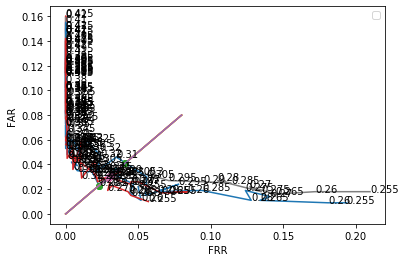

In [81]:
##################################################
# 2000 pair - 25 samnple
#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

#5. all subject , all subject
counter_true_false_result(0,107, 0,107)

Successfully created the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 
0.255 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 970 FN: 30 FRR: 0.03 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.020499999999999997 

0.26 . 
 97.4 % 
 true_result: 1948 false_result: 52 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.026000000000000002 

0.265 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.025 

0.27 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.024 

0.275 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 988 FN: 12 FRR: 0.012 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.02 

0.28 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 989 FN: 11 FRR: 0.011 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.020999999999999998 

0.285 . 
 98.1 % 
 true_result: 1962 false_resu

No handles with labels found to put in legend.


0.42 . 
 91.3 % 
 true_result: 1826 false_result: 174 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 826 FP: 174 FAR: 0.174 
 EER: 0.087 

POINT (0.02466666666666667 0.02466666666666667)
###S1(0-89)_S2(0-89)


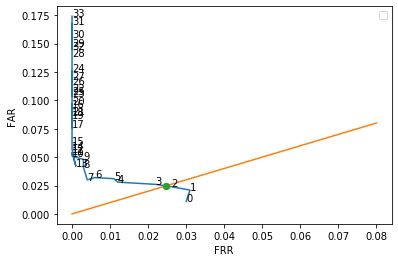

In [34]:
##################################################
# 2000 pair - 25 samnple - best point model
#1. train subject , train subject
counter_true_false_result(0,89, 0,89)



Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.255 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.023 

0.26 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 975 FN: 25 FRR: 0.025 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.0245 

0.265 . 
 97.4 % 
 true_result: 1948 false_result: 52 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.026000000000000002 

0.27 . 
 98.05 % 
 true_result: 1961 false_result: 39 
 TP: 985 FN: 15 FRR: 0.015 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.0195 

0.275 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 987 FN: 13 FRR: 0.013 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.0215 

0.28 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 990 FN: 10 FRR: 0.01 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.0245 

0.285 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 995 FN: 5 FRR

No handles with labels found to put in legend.


0.42 . 
 91.45 % 
 true_result: 1829 false_result: 171 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 829 FP: 171 FAR: 0.171 
 EER: 0.0855 

POINT (0.024 0.024)
###S1(0-89)_S2(90-107)


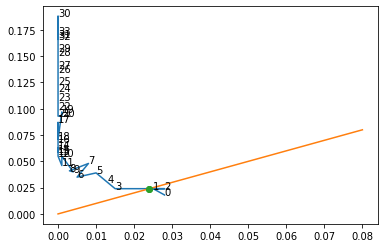

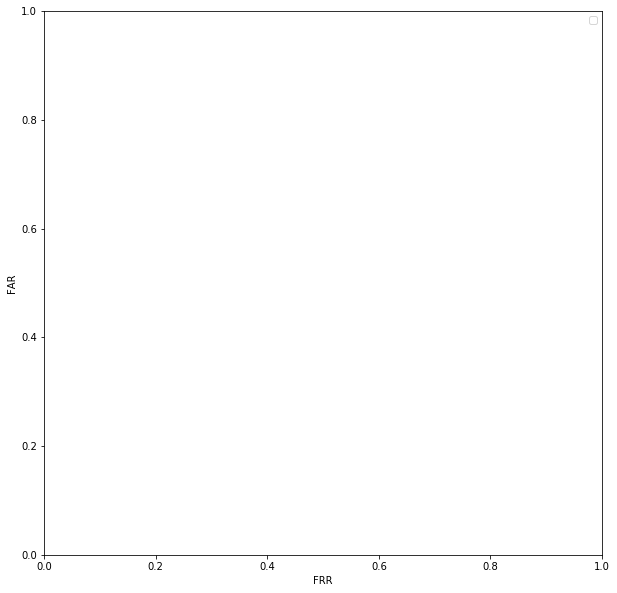

In [36]:
#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.245 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 868 FN: 132 FRR: 0.132 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.07400000000000001 

0.25 . 
 94.3 % 
 true_result: 1886 false_result: 114 
 TP: 906 FN: 94 FRR: 0.094 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.057 

0.255 . 
 95.05 % 
 true_result: 1901 false_result: 99 
 TP: 920 FN: 80 FRR: 0.08 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0495 

0.26 . 
 95.6 % 
 true_result: 1912 false_result: 88 
 TP: 931 FN: 69 FRR: 0.069 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.044000000000000004 

0.265 . 
 96.45 % 
 true_result: 1929 false_result: 71 
 TP: 954 FN: 46 FRR: 0.046 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.035500000000000004 

0.27 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.024 

0.275 . 
 97.15 % 
 true_result: 1943 false_re

No handles with labels found to put in legend.


0.41 . 
 91.45 % 
 true_result: 1829 false_result: 171 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 829 FP: 171 FAR: 0.171 
 EER: 0.0855 

POINT (0.024 0.024)
###S1(90-107)_S2(0-89)


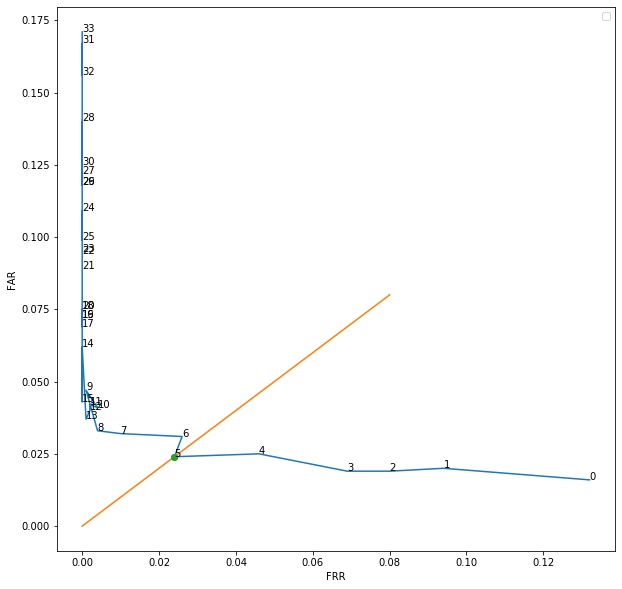

In [42]:
#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.245 . 
 93.75 % 
 true_result: 1875 false_result: 125 
 TP: 881 FN: 119 FRR: 0.119 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.0625 

0.25 . 
 94.75 % 
 true_result: 1895 false_result: 105 
 TP: 897 FN: 103 FRR: 0.103 
 TN: 998 FP: 2 FAR: 0.002 
 EER: 0.0525 

0.255 . 
 95.35 % 
 true_result: 1907 false_result: 93 
 TP: 911 FN: 89 FRR: 0.089 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.0465 

0.26 . 
 96.65 % 
 true_result: 1933 false_result: 67 
 TP: 939 FN: 61 FRR: 0.061 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.0335 

0.265 . 
 97.05 % 
 true_result: 1941 false_result: 59 
 TP: 949 FN: 51 FRR: 0.051 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.0295 

0.27 . 
 98.15 % 
 true_result: 1963 false_result: 37 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0185 

0.275 . 
 97.75 % 
 true_result: 1955 false_result: 45 
 TP: 970 FN: 30 FRR: 0.03 


No handles with labels found to put in legend.


0.41 . 
 92.1 % 
 true_result: 1842 false_result: 158 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 842 FP: 158 FAR: 0.158 
 EER: 0.079 

POINT (0.02035714285714286 0.02035714285714286)
###S1(90-107)_S2(90-107)


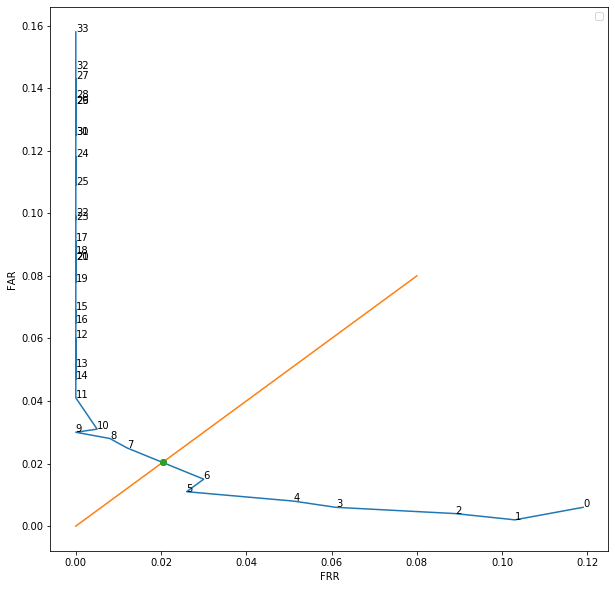

In [43]:
#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.245 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.038 

0.25 . 
 96.9 % 
 true_result: 1938 false_result: 62 
 TP: 948 FN: 52 FRR: 0.052 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.031 

0.255 . 
 97.4 % 
 true_result: 1948 false_result: 52 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.026000000000000002 

0.26 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.025 

0.265 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 973 FN: 27 FRR: 0.027 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.022 

0.27 . 
 97.4 % 
 true_result: 1948 false_result: 52 
 TP: 975 FN: 25 FRR: 0.025 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.026000000000000002 

0.275 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 982 F

No handles with labels found to put in legend.


0.41 . 
 91.6 % 
 true_result: 1832 false_result: 168 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 832 FP: 168 FAR: 0.168 
 EER: 0.084 

POINT (0.02533333333333333 0.02533333333333334)
###S1(0-107)_S2(0-107)


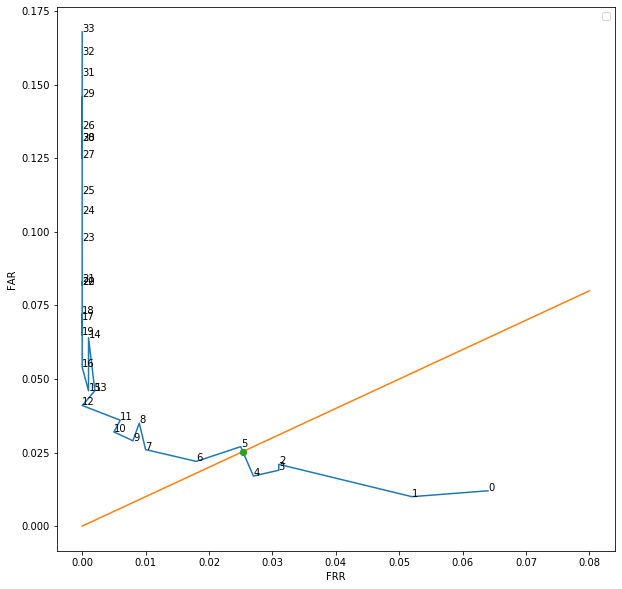

In [44]:
#5. all subject , all subject
counter_true_false_result(0,107, 0,107)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.23 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 912 FN: 88 FRR: 0.088 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.048999999999999995 

0.235 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 908 FN: 92 FRR: 0.092 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0515 

0.24 . 
 95.5 % 
 true_result: 1910 false_result: 90 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.045 

0.245 . 
 95.85 % 
 true_result: 1917 false_result: 83 
 TP: 933 FN: 67 FRR: 0.067 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0415 

0.25 . 
 97.15 % 
 true_result: 1943 false_result: 57 
 TP: 959 FN: 41 FRR: 0.041 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0285 

0.255 . 
 96.85 % 
 true_result: 1937 false_result: 63 
 TP: 956 FN: 44 FRR: 0.044 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0315 

0.26 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 963 FN: 37 F

No handles with labels found to put in legend.


0.395 . 
 93.35 % 
 true_result: 1867 false_result: 133 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 867 FP: 133 FAR: 0.133 
 EER: 0.0665 

POINT (0.02233333333333333 0.02233333333333333)
###S1(0-107)_S2(0-107)


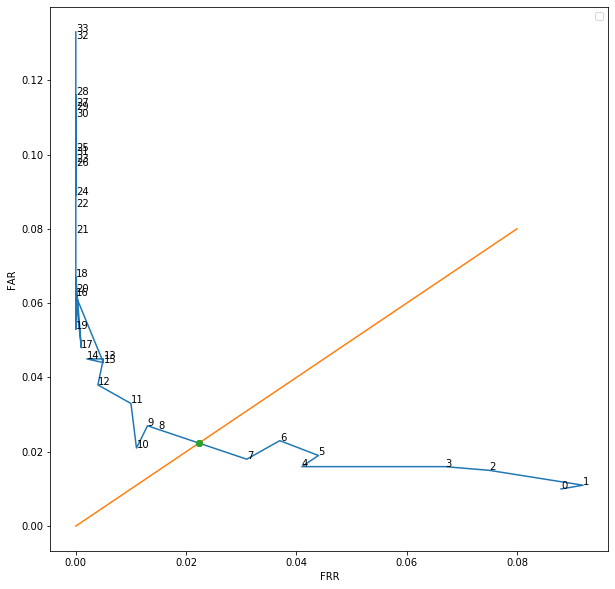

In [46]:
#5. all subject , all subject
counter_true_false_result(0,107, 0,107)

Successfully created the directory /content/drive/My Drive/Orth_cosian/try2 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 
0.23 . 
 95.95 % 
 true_result: 1919 false_result: 81 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.0405 

0.235 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.038 

0.24 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0305 

0.245 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 957 FN: 43 FRR: 0.043 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.03 

0.25 . 
 97.25 % 
 true_result: 1945 false_result: 55 
 TP: 964 FN: 36 FRR: 0.036 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.027499999999999997 

0.255 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 951 FN: 49 FRR: 0.049 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.03 

0.26 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 979 FN: 21 FRR

No handles with labels found to put in legend.


0.295 . 
 98.05 % 
 true_result: 1961 false_result: 39 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.019500000000000003 

MULTIPOINT (0.01722222222222222 0.01722222222222222, 0.01942105263157895 0.01942105263157895, 0.0224 0.0224)
###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.23 . 
 95.45 % 
 true_result: 1909 false_result: 91 
 TP: 917 FN: 83 FRR: 0.083 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.0455 

0.235 . 
 96.05 % 
 true_result: 1921 false_result: 79 
 TP: 933 FN: 67 FRR: 0.067 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.0395 

0.24 . 
 95.8 % 
 true_result: 1916 false_result: 84 
 TP: 933 FN: 67 FRR: 0.067 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.042 

0.245 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 951 FN: 49 FRR: 0.049 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.03 

0.25 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 962 FN: 38 F

No handles with labels found to put in legend.


0.295 . 
 97.35 % 
 true_result: 1947 false_result: 53 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 951 FP: 49 FAR: 0.049 
 EER: 0.026500000000000003 

POINT (0.02181818181818182 0.02181818181818182)
###S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.23 . 
 89.5 % 
 true_result: 1790 false_result: 210 
 TP: 794 FN: 206 FRR: 0.206 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.105 

0.235 . 
 89.95 % 
 true_result: 1799 false_result: 201 
 TP: 807 FN: 193 FRR: 0.193 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.1005 

0.24 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 856 FN: 144 FRR: 0.144 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.074 

0.245 . 
 92.3 % 
 true_result: 1846 false_result: 154 
 TP: 862 FN: 138 FRR: 0.138 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.07700000000000001 

0.25 . 
 94.2 % 
 true_result: 1884 false_result: 116 
 TP: 898 FN: 102 FRR: 0.102 
 TN: 986 FP: 14 FAR: 0.014 

No handles with labels found to put in legend.


POINT (0.026 0.026)
###S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.23 . 
 90.25 % 
 true_result: 1805 false_result: 195 
 TP: 806 FN: 194 FRR: 0.194 
 TN: 999 FP: 1 FAR: 0.001 
 EER: 0.0975 

0.235 . 
 89.85 % 
 true_result: 1797 false_result: 203 
 TP: 798 FN: 202 FRR: 0.202 
 TN: 999 FP: 1 FAR: 0.001 
 EER: 0.1015 

0.24 . 
 91.45 % 
 true_result: 1829 false_result: 171 
 TP: 829 FN: 171 FRR: 0.171 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.0855 

0.245 . 
 94.15 % 
 true_result: 1883 false_result: 117 
 TP: 884 FN: 116 FRR: 0.116 
 TN: 999 FP: 1 FAR: 0.001 
 EER: 0.0585 

0.25 . 
 94.6 % 
 true_result: 1892 false_result: 108 
 TP: 895 FN: 105 FRR: 0.105 
 TN: 997 FP: 3 FAR: 0.003 
 EER: 0.054 

0.255 . 
 95.0 % 
 true_result: 1900 false_result: 100 
 TP: 906 FN: 94 FRR: 0.094 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.05 

0.26 . 
 96.8 % 
 true_result: 1936 fals

No handles with labels found to put in legend.


0.295 . 
 98.5 % 
 true_result: 1970 false_result: 30 
 TP: 999 FN: 1 FRR: 0.001 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.015000000000000001 

POINT (0.01258333333333333 0.01258333333333333)
###S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.23 . 
 93.95 % 
 true_result: 1879 false_result: 121 
 TP: 893 FN: 107 FRR: 0.107 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0605 

0.235 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 910 FN: 90 FRR: 0.09 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0515 

0.24 . 
 95.95 % 
 true_result: 1919 false_result: 81 
 TP: 932 FN: 68 FRR: 0.068 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0405 

0.245 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.038 

0.25 . 
 96.75 % 
 true_result: 1935 false_result: 65 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.0325 

No handles with labels found to put in legend.


0.295 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 994 FN: 6 FRR: 0.006 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.0205 

POINT (0.02565217391304348 0.02565217391304348)
###S1(0-108)_S2(0-108)


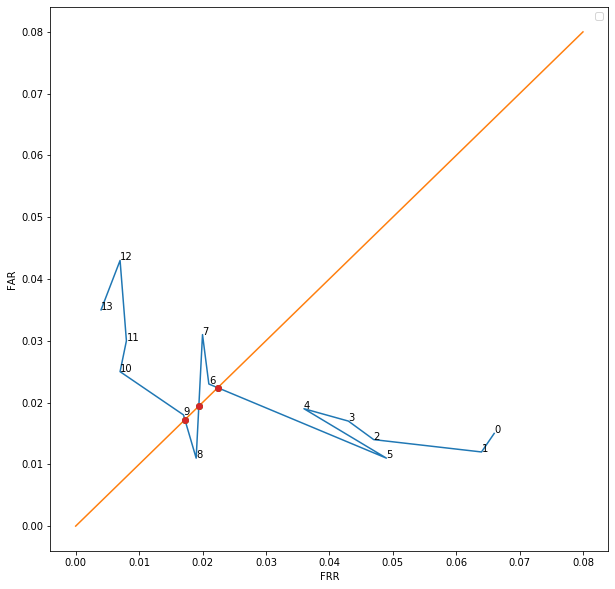

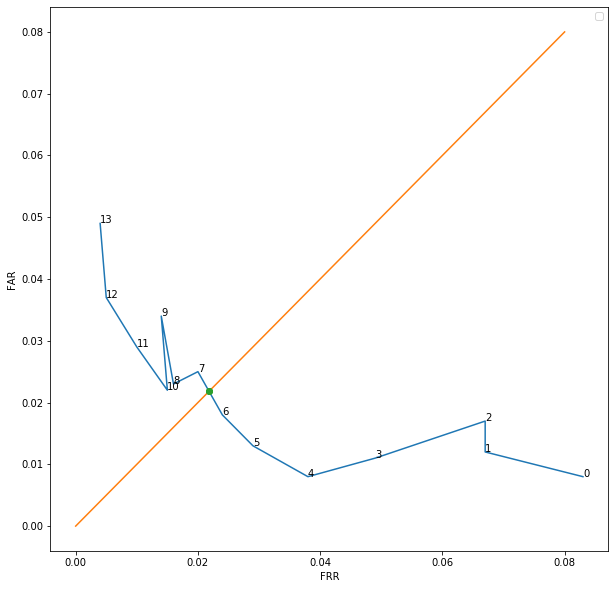

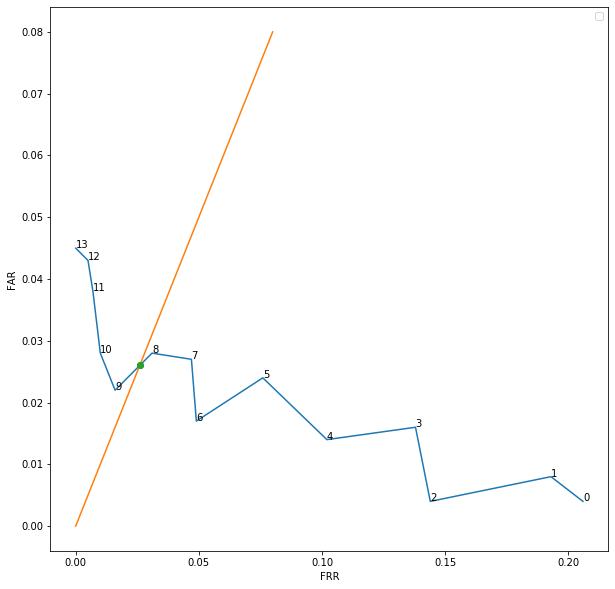

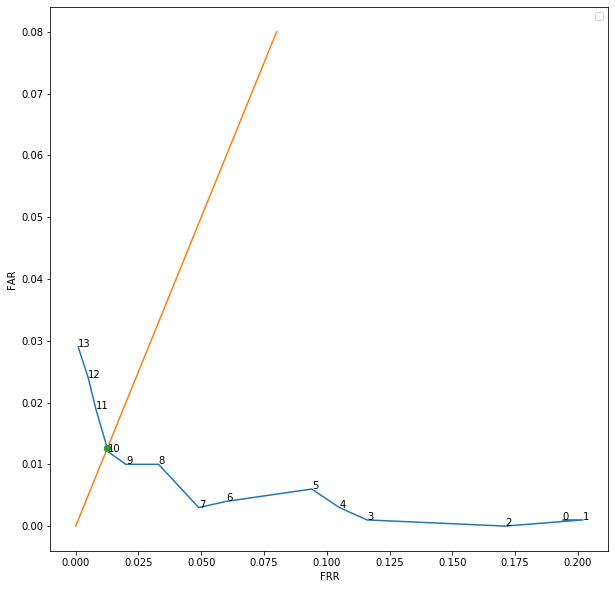

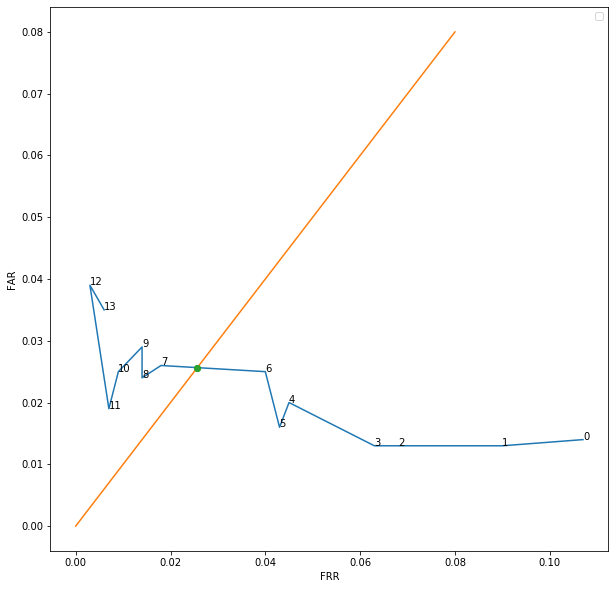

In [50]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Successfully created the directory /content/drive/My Drive/Orth_cosian/try3 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 
1 )  0.227 . 
 96.15 % 
 true_result: 1923 false_result: 77 
 TP: 927 FN: 73 FRR: 0.073 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.0385 

2 )  0.229 . 
 96.4 % 
 true_result: 1928 false_result: 72 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.036000000000000004 

3 )  0.231 . 
 95.9 % 
 true_result: 1918 false_result: 82 
 TP: 926 FN: 74 FRR: 0.074 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.040999999999999995 

4 )  0.233 . 
 96.55 % 
 true_result: 1931 false_result: 69 
 TP: 943 FN: 57 FRR: 0.057 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.0345 

5 )  0.235 . 
 96.1 % 
 true_result: 1922 false_result: 78 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.039 

6 )  0.237 . 
 96.65 % 
 true_result: 1933 false_result: 67 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 993 FP: 7 FAR: 0.007 
 EER: 0.0335 

7 )  0.239 . 
 97.05 % 
 tr

No handles with labels found to put in legend.


24 )  0.273 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 984 FN: 16 FRR: 0.016 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.02 

MULTIPOINT (0.0206 0.0206, 0.0215 0.0215, 0.02266666666666667 0.02266666666666666)
###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
1 )  0.227 . 
 96.25 % 
 true_result: 1925 false_result: 75 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0375 

2 )  0.229 . 
 96.0 % 
 true_result: 1920 false_result: 80 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 995 FP: 5 FAR: 0.005 
 EER: 0.04 

3 )  0.231 . 
 95.95 % 
 true_result: 1919 false_result: 81 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.0405 

4 )  0.233 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.033 

5 )  0.235 . 
 95.9 % 
 true_result: 1918 false_result: 82 
 TP: 931 FN: 69 FRR: 0.069 

No handles with labels found to put in legend.


24 )  0.273 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 982 FN: 18 FRR: 0.018 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.0245 

MULTIPOINT (0.02041176470588235 0.02041176470588235, 0.0241875 0.0241875, 0.0246 0.0246)
###S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
1 )  0.227 . 
 88.0 % 
 true_result: 1760 false_result: 240 
 TP: 775 FN: 225 FRR: 0.225 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.12 

2 )  0.229 . 
 87.8 % 
 true_result: 1756 false_result: 244 
 TP: 771 FN: 229 FRR: 0.229 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.122 

3 )  0.231 . 
 89.0 % 
 true_result: 1780 false_result: 220 
 TP: 788 FN: 212 FRR: 0.212 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.11 

4 )  0.233 . 
 88.55 % 
 true_result: 1771 false_result: 229 
 TP: 783 FN: 217 FRR: 0.217 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.1145 

5 )  0.235 . 
 89.95 % 
 true_result: 1799 false_result: 201 
 TP: 81

No handles with labels found to put in legend.


24 )  0.273 . 
 97.3 % 
 true_result: 1946 false_result: 54 
 TP: 967 FN: 33 FRR: 0.033 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.027000000000000003 

MULTIPOINT (0.02542105263157895 0.02542105263157895, 0.02594117647058823 0.02594117647058823)
###S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
1 )  0.227 . 
 88.45 % 
 true_result: 1769 false_result: 231 
 TP: 769 FN: 231 FRR: 0.231 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.1155 

2 )  0.229 . 
 89.3 % 
 true_result: 1786 false_result: 214 
 TP: 787 FN: 213 FRR: 0.213 
 TN: 999 FP: 1 FAR: 0.001 
 EER: 0.107 

3 )  0.231 . 
 89.8 % 
 true_result: 1796 false_result: 204 
 TP: 796 FN: 204 FRR: 0.204 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.102 

4 )  0.233 . 
 89.9 % 
 true_result: 1798 false_result: 202 
 TP: 798 FN: 202 FRR: 0.202 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.101 

5 )  0.235 . 
 89.75 % 
 true_result: 1795 false_result

No handles with labels found to put in legend.


24 )  0.273 . 
 98.1 % 
 true_result: 1962 false_result: 38 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.019 

LINESTRING EMPTY
###S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3 best point model- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
1 )  0.227 . 
 94.05 % 
 true_result: 1881 false_result: 119 
 TP: 888 FN: 112 FRR: 0.112 
 TN: 993 FP: 7 FAR: 0.007 
 EER: 0.059500000000000004 

2 )  0.229 . 
 93.25 % 
 true_result: 1865 false_result: 135 
 TP: 875 FN: 125 FRR: 0.125 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.0675 

3 )  0.231 . 
 94.25 % 
 true_result: 1885 false_result: 115 
 TP: 895 FN: 105 FRR: 0.105 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.057499999999999996 

4 )  0.233 . 
 94.45 % 
 true_result: 1889 false_result: 111 
 TP: 897 FN: 103 FRR: 0.103 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.055499999999999994 

5 )  0.235 . 
 95.7 % 
 true_result: 1914 false_result: 86 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 98

No handles with labels found to put in legend.


24 )  0.273 . 
 98.3 % 
 true_result: 1966 false_result: 34 
 TP: 987 FN: 13 FRR: 0.013 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.017 

POINT (0.0225 0.0225)
###S1(0-108)_S2(0-108)


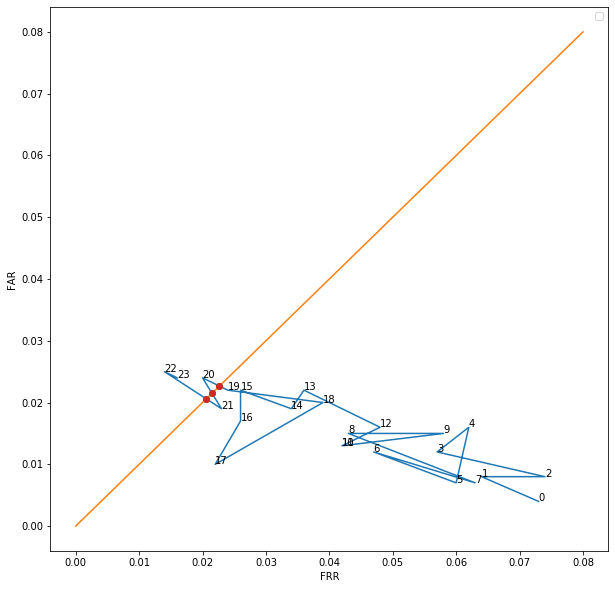

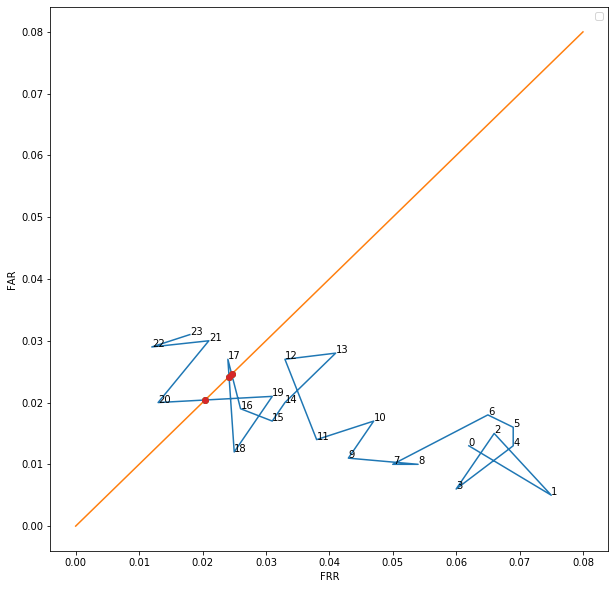

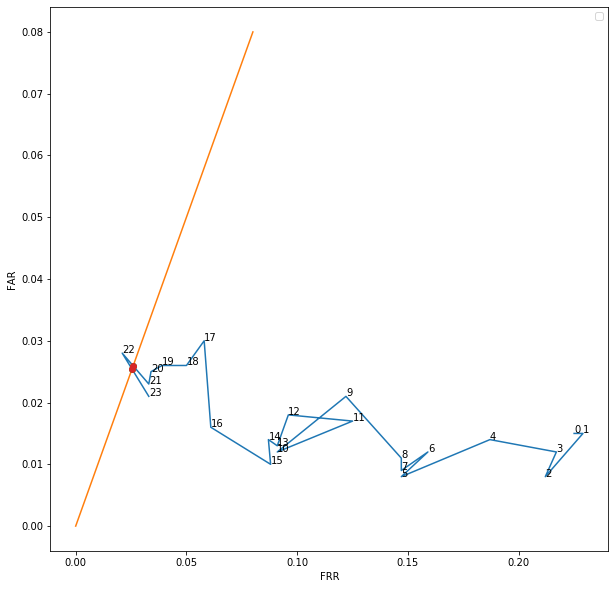

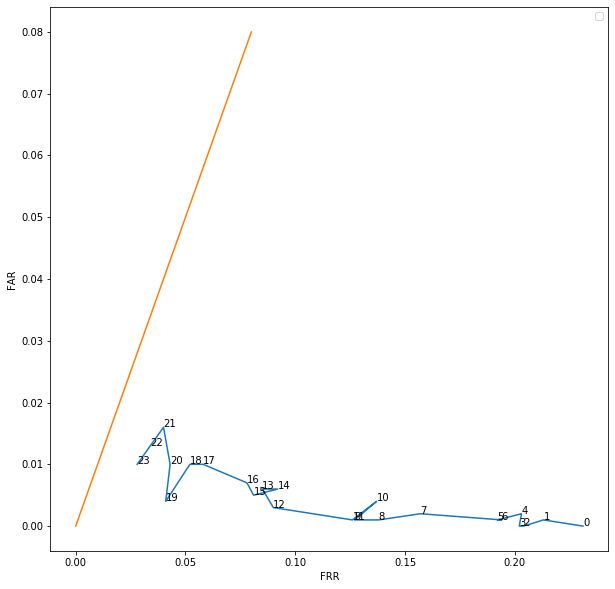

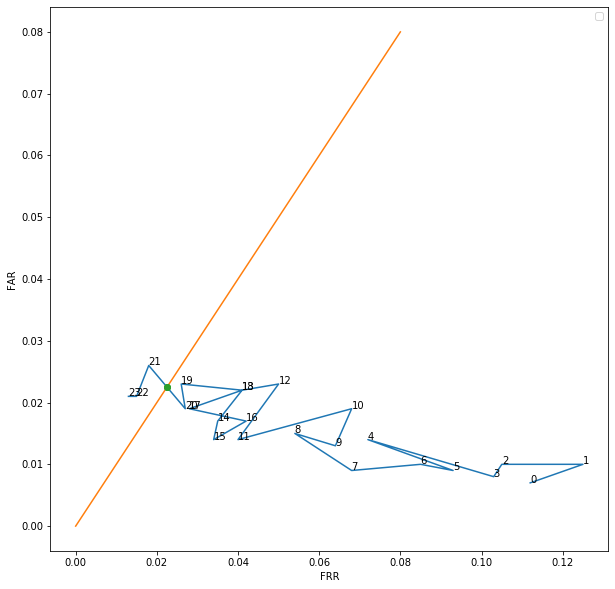

In [54]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1 2h5 file- cosian dist_true ORTH new model25sample num_3000pair_ouer shift160 failed
0.255 . 
 96.76666666666667 % 
 true_result: 2903 false_result: 97 
 TP: 1426 FN: 74 FRR: 0.04933333333333333 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.03233333333333333 

0.26 . 
 96.23333333333333 % 
 true_result: 2887 false_result: 113 
 TP: 1410 FN: 90 FRR: 0.06 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.03766666666666667 

0.265 . 
 96.56666666666666 % 
 true_result: 2897 false_result: 103 
 TP: 1423 FN: 77 FRR: 0.051333333333333335 
 TN: 1474 FP: 26 FAR: 0.017333333333333333 
 EER: 0.034333333333333334 

0.27 . 
 97.23333333333333 % 
 true_result: 2917 false_result: 83 
 TP: 1440 FN: 60 FRR: 0.04 
 TN: 1477 FP: 23 FAR: 0.015333333333333332 
 EER: 0.027666666666666666 

0.275 . 
 96.96666666666667 % 
 true_result: 2909 false_result: 91 
 TP: 1439 FN: 61 FRR: 0.04066666666666666 
 TN: 1470 FP: 30 FAR: 0.02 
 EER:

No handles with labels found to put in legend.


0.42 . 
 91.7 % 
 true_result: 2751 false_result: 249 
 TP: 1500 FN: 0 FRR: 0.0 
 TN: 1251 FP: 249 FAR: 0.166 
 EER: 0.083 

POINT (0.03020689655172414 0.03020689655172414)
###S1(0-89)_S2(90-108)


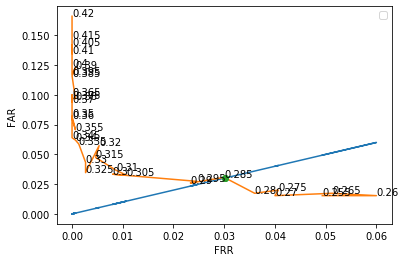

In [72]:
#1. train subject , train subject
counter_true_false_result(0,89, 90,108) 

In [0]:
#####################################
# try2 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try2 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.024 

0.254 . 
 98.4 % 
 true_result: 1968 false_result: 32 
 TP: 980 FN: 20 FRR: 0.02 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.016 

0.256 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.022 

0.258 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.023 

0.26 . 
 98.25 % 
 true_result: 1965 false_result: 35 
 TP: 979 FN: 21 FRR: 0.021 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0175 

0.262 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.022 

0.264 . 
 98.1 % 
 true_result: 1962 false_result: 38 
 TP: 978 F

No handles with labels found to put in legend.


0.288 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 963 FP: 37 FAR: 0.037 
 EER: 0.020499999999999997 



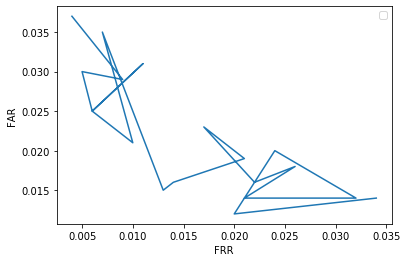

In [0]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try2 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 967 FN: 33 FRR: 0.033 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.024 

0.254 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0215 

0.256 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.02 

0.258 . 
 97.75 % 
 true_result: 1955 false_result: 45 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0225 

0.26 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 975 FN: 25 FRR: 0.025 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0205 

0.262 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 979 FN: 21 FRR: 0.021 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.021 

0.264 . 
 98.05 % 
 true_result: 1961 false_result: 39 
 TP:

No handles with labels found to put in legend.


0.288 . 
 98.2 % 
 true_result: 1964 false_result: 36 
 TP: 994 FN: 6 FRR: 0.006 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.018 



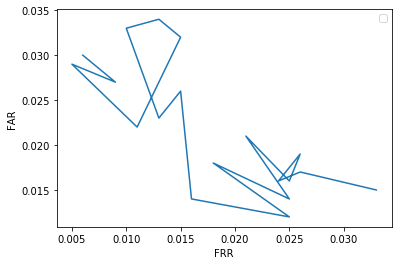

In [0]:
#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try2 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 94.15 % 
 true_result: 1883 false_result: 117 
 TP: 908 FN: 92 FRR: 0.092 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.058499999999999996 

0.254 . 
 94.8 % 
 true_result: 1896 false_result: 104 
 TP: 914 FN: 86 FRR: 0.086 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.052 

0.256 . 
 94.95 % 
 true_result: 1899 false_result: 101 
 TP: 921 FN: 79 FRR: 0.079 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.0505 

0.258 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 922 FN: 78 FRR: 0.078 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.049 

0.26 . 
 95.5 % 
 true_result: 1910 false_result: 90 
 TP: 933 FN: 67 FRR: 0.067 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.045 

0.262 . 
 96.05 % 
 true_result: 1921 false_result: 79 
 TP: 944 FN: 56 FRR: 0.056 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0395 

0.264 . 
 96.45 % 
 true_result: 1929 false

No handles with labels found to put in legend.


0.288 . 
 98.2 % 
 true_result: 1964 false_result: 36 
 TP: 994 FN: 6 FRR: 0.006 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.018 



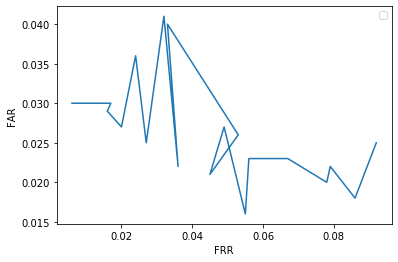

In [0]:
#3. new subject , new subject

counter_true_false_result(90,107, 0,89)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try2 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 94.75 % 
 true_result: 1895 false_result: 105 
 TP: 906 FN: 94 FRR: 0.094 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0525 

0.254 . 
 95.35 % 
 true_result: 1907 false_result: 93 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.0465 

0.256 . 
 95.6 % 
 true_result: 1912 false_result: 88 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.044 

0.258 . 
 95.8 % 
 true_result: 1916 false_result: 84 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.041999999999999996 

0.26 . 
 96.4 % 
 true_result: 1928 false_result: 72 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.036000000000000004 

0.262 . 
 96.75 % 
 true_result: 1935 false_result: 65 
 TP: 941 FN: 59 FRR: 0.059 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.0325 

0.264 . 
 96.15 % 
 true_result:

No handles with labels found to put in legend.


0.288 . 
 99.0 % 
 true_result: 1980 false_result: 20 
 TP: 994 FN: 6 FRR: 0.006 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.01 



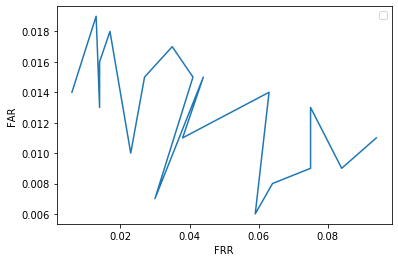

In [0]:
#4. new subject , new subject

counter_true_false_result(90,107, 90,107)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try2 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 961 FN: 39 FRR: 0.039 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.0305 

0.254 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0235 

0.256 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 952 FN: 48 FRR: 0.048 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.033 

0.258 . 
 97.35 % 
 true_result: 1947 false_result: 53 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.026500000000000003 

0.26 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 960 FN: 40 FRR: 0.04 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.0305 

0.262 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 967 FN: 33 FRR: 0.033 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.024 

0.264 . 
 97.7 % 
 true_result: 1954 false_r

No handles with labels found to put in legend.


0.288 . 
 98.5 % 
 true_result: 1970 false_result: 30 
 TP: 995 FN: 5 FRR: 0.005 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.015000000000000001 



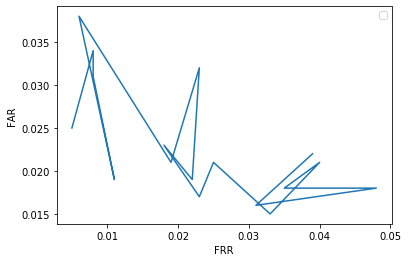

In [0]:
#5. all subject , all subject

counter_true_false_result(0,107, 0,107)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try3 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.024 

0.254 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.021500000000000002 

0.256 . 
 98.2 % 
 true_result: 1964 false_result: 36 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.018000000000000002 

0.258 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 980 FN: 20 FRR: 0.02 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.0205 

0.26 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 973 FN: 27 FRR: 0.027 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.023 

0.262 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.023 

0.264 . 
 98.1 % 
 true_result: 19

No handles with labels found to put in legend.


0.288 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 991 FN: 9 FRR: 0.009 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.0245 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try3 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.15 % 
 true_result: 1943 false_result: 57 
 TP: 964 FN: 36 FRR: 0.036 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.028499999999999998 

0.254 . 
 98.05 % 
 true_result: 1961 false_result: 39 
 TP: 979 FN: 21 FRR: 0.021 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.0195 

0.256 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 980 FN: 20 FRR: 0.02 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.020999999999999998 

0.258 . 
 97.1 % 
 true_result: 1942 false_result: 58 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.029 

0.26 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 977 FN: 23 FRR: 0.023 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.023 

0.262 . 
 97.8 % 
 true_result: 1

No handles with labels found to put in legend.


0.288 . 
 98.3 % 
 true_result: 1966 false_result: 34 
 TP: 998 FN: 2 FRR: 0.002 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.017 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try3 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.0 % 
 true_result: 1900 false_result: 100 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.05 

0.254 . 
 95.7 % 
 true_result: 1914 false_result: 86 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.043 

0.256 . 
 94.9 % 
 true_result: 1898 false_result: 102 
 TP: 919 FN: 81 FRR: 0.081 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.051000000000000004 

0.258 . 
 96.15 % 
 true_result: 1923 false_result: 77 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0385 

0.26 . 
 95.15 % 
 true_result: 1903 false_result: 97 
 TP: 926 FN: 74 FRR: 0.074 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0485 

0.262 . 
 96.6 % 
 true_result: 1932 false_res

No handles with labels found to put in legend.


0.288 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 986 FN: 14 FRR: 0.014 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.024999999999999998 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try3 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.5 % 
 true_result: 1910 false_result: 90 
 TP: 914 FN: 86 FRR: 0.086 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.045 

0.254 . 
 95.6 % 
 true_result: 1912 false_result: 88 
 TP: 918 FN: 82 FRR: 0.082 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.044000000000000004 

0.256 . 
 96.3 % 
 true_result: 1926 false_result: 74 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.037 

0.258 . 
 96.05 % 
 true_result: 1921 false_result: 79 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0395 

0.26 . 
 97.05 % 
 true_result: 1941 false_result: 59 
 TP: 947 FN: 53 FRR: 0.053 
 TN: 994 FP: 6 FAR: 0.006 
 EER: 0.0295 

0.262 . 
 97.05 % 
 true_result: 1

No handles with labels found to put in legend.


0.288 . 
 98.6 % 
 true_result: 1972 false_result: 28 
 TP: 988 FN: 12 FRR: 0.012 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.014 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try3 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.25 % 
 true_result: 1945 false_result: 55 
 TP: 964 FN: 36 FRR: 0.036 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.027499999999999997 

0.254 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.023 

0.256 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 960 FN: 40 FRR: 0.04 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.0305 

0.258 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 967 FN: 33 FRR: 0.033 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0245 

0.26 . 
 98.25 % 
 true_result: 1965 false_result: 35 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.017499999999999998 

0.262 . 
 97.55 % 
 true_resul

No handles with labels found to put in legend.


0.288 . 
 98.4 % 
 true_result: 1968 false_result: 32 
 TP: 993 FN: 7 FRR: 0.007 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.016 



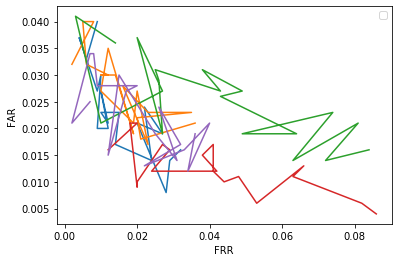

In [0]:
# Try3

#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

#5. all subject , all subject
counter_true_false_result(0,107, 0,107)



Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try4 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.35 % 
 true_result: 1947 false_result: 53 
 TP: 970 FN: 30 FRR: 0.03 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0265 

0.254 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0245 

0.256 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.020499999999999997 

0.258 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.0215 

0.26 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.024 

0.262 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 970 FN: 30 FRR: 0.03 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.025 

0.264 . 
 98.45 % 
 true_result: 1969 false_re

No handles with labels found to put in legend.


0.288 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 994 FN: 6 FRR: 0.006 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.02 

###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try4 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.75 % 
 true_result: 1955 false_result: 45 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0225 

0.254 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 993 FP: 7 FAR: 0.007 
 EER: 0.0205 

0.256 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0235 

0.258 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.022 

0.26 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.023 

0.262 . 
 98.5 % 
 true_result: 1970 fals

No handles with labels found to put in legend.


0.288 . 
 98.25 % 
 true_result: 1965 false_result: 35 
 TP: 993 FN: 7 FRR: 0.007 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.0175 

###S1(0-89)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try4 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.25 % 
 true_result: 1905 false_result: 95 
 TP: 922 FN: 78 FRR: 0.078 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0475 

0.254 . 
 95.05 % 
 true_result: 1901 false_result: 99 
 TP: 920 FN: 80 FRR: 0.08 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0495 

0.256 . 
 95.9 % 
 true_result: 1918 false_result: 82 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.041 

0.258 . 
 95.2 % 
 true_result: 1904 false_result: 96 
 TP: 921 FN: 79 FRR: 0.079 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.048 

0.26 . 
 95.25 % 
 true_result: 1905 false_result: 95 
 TP: 923 FN: 77 FRR: 0.077 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.0475 

0.262 . 
 96.55 % 
 true_result: 1931

No handles with labels found to put in legend.


0.288 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 987 FN: 13 FRR: 0.013 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.024499999999999997 

###S1(90-107)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try4 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.3 % 
 true_result: 1906 false_result: 94 
 TP: 913 FN: 87 FRR: 0.087 
 TN: 993 FP: 7 FAR: 0.007 
 EER: 0.047 

0.254 . 
 94.45 % 
 true_result: 1889 false_result: 111 
 TP: 898 FN: 102 FRR: 0.102 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.055499999999999994 

0.256 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.038 

0.258 . 
 95.95 % 
 true_result: 1919 false_result: 81 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.040499999999999994 

0.26 . 
 96.5 % 
 true_result: 1930 false_result: 70 
 TP: 941 FN: 59 FRR: 0.059 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.03

No handles with labels found to put in legend.


0.288 . 
 98.55 % 
 true_result: 1971 false_result: 29 
 TP: 988 FN: 12 FRR: 0.012 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0145 

###S1(90-107)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try4 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.2 % 
 true_result: 1944 false_result: 56 
 TP: 956 FN: 44 FRR: 0.044 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.027999999999999997 

0.254 . 
 96.6 % 
 true_result: 1932 false_result: 68 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.034 

0.256 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.0235 

0.258 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.020999999999999998 

0.26 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 977 FN: 23 FRR: 0.023 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.02049999999

No handles with labels found to put in legend.


0.288 . 
 98.2 % 
 true_result: 1964 false_result: 36 
 TP: 997 FN: 3 FRR: 0.003 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.018000000000000002 

###S1(0-107)_S2(0-107)


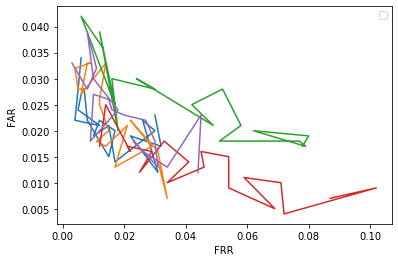

In [0]:
# Try4

#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

#5. all subject , all subject
counter_true_false_result(0,107, 0,107)



Successfully created the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try5 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 
0.252 . 
 98.3 % 
 true_result: 1966 false_result: 34 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.017 

0.254 . 
 97.3 % 
 true_result: 1946 false_result: 54 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.027 

0.256 . 
 97.45 % 
 true_result: 1949 false_result: 51 
 TP: 970 FN: 30 FRR: 0.03 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.025500000000000002 

0.258 . 
 98.05 % 
 true_result: 1961 false_result: 39 
 TP: 977 FN: 23 FRR: 0.023 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0195 

0.26 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.020999999999999998 

0.262 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.020999999999999998 

0.264 . 
 97.6 % 

No handles with labels found to put in legend.


0.288 . 
 98.25 % 
 true_result: 1965 false_result: 35 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.0175 

###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try5 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.0245 

0.254 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.024 

0.256 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.021500000000000002 

0.258 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 974 FN: 26 FRR: 0.026 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.024 

0.26 . 
 98.2 % 
 true_result: 1964 false_result: 36 
 TP: 982 FN: 18 FRR: 0.018 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.018 

0.262 . 
 98.55 % 
 true_

No handles with labels found to put in legend.


0.288 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.019999999999999997 

###S1(0-89)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try5 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 94.9 % 
 true_result: 1898 false_result: 102 
 TP: 912 FN: 88 FRR: 0.088 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.051 

0.254 . 
 95.5 % 
 true_result: 1910 false_result: 90 
 TP: 921 FN: 79 FRR: 0.079 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.045 

0.256 . 
 94.55 % 
 true_result: 1891 false_result: 109 
 TP: 918 FN: 82 FRR: 0.082 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.0545 

0.258 . 
 96.05 % 
 true_result: 1921 false_result: 79 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0395 

0.26 . 
 95.6 % 
 true_result: 1912 false_result: 88 
 TP: 923 FN: 77 FRR: 0.077 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.044 

0.262 . 
 95.2 % 
 tru

No handles with labels found to put in legend.


0.288 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 985 FN: 15 FRR: 0.015 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.0215 

###S1(90-107)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try5 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.25 % 
 true_result: 1905 false_result: 95 
 TP: 915 FN: 85 FRR: 0.085 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.0475 

0.254 . 
 96.1 % 
 true_result: 1922 false_result: 78 
 TP: 927 FN: 73 FRR: 0.073 
 TN: 995 FP: 5 FAR: 0.005 
 EER: 0.039 

0.256 . 
 95.4 % 
 true_result: 1908 false_result: 92 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 992 FP: 8 FAR: 0.008 
 EER: 0.046 

0.258 . 
 95.8 % 
 true_result: 1916 false_result: 84 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.041999999999999996 

0.26 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 951 FN: 49 FRR: 0.049 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.033 

0.262 . 
 96.55 % 
 true_r

No handles with labels found to put in legend.


0.288 . 
 98.75 % 
 true_result: 1975 false_result: 25 
 TP: 991 FN: 9 FRR: 0.009 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0125 

###S1(90-107)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try5 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.2 % 
 true_result: 1944 false_result: 56 
 TP: 960 FN: 40 FRR: 0.04 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.028 

0.254 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 969 FN: 31 FRR: 0.031 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.020999999999999998 

0.256 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 961 FN: 39 FRR: 0.039 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.025 

0.258 . 
 97.15 % 
 true_result: 1943 false_result: 57 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.0285 

0.26 . 
 97.2 % 
 true_result: 1944 false_result: 56 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.028 

0.262 . 
 97.85 % 
 tru

No handles with labels found to put in legend.


0.288 . 
 98.6 % 
 true_result: 1972 false_result: 28 
 TP: 993 FN: 7 FRR: 0.007 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.014 

###S1(0-107)_S2(0-107)


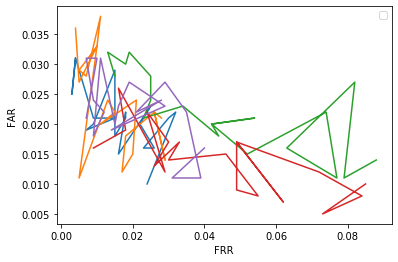

In [0]:
# Try5

#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

#5. all subject , all subject
counter_true_false_result(0,107, 0,107)



Successfully created the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try6 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 
0.252 . 
 97.7 % 
 true_result: 1954 false_result: 46 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.023 

0.254 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.022 

0.256 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.021500000000000002 

0.258 . 
 98.35 % 
 true_result: 1967 false_result: 33 
 TP: 983 FN: 17 FRR: 0.017 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0165 

0.26 . 
 98.25 % 
 true_result: 1965 false_result: 35 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.017499999999999998 

0.262 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 979 FN: 21 FRR: 0.021 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.0205 

0.264 . 
 97.75 % 
 true_re

No handles with labels found to put in legend.


0.288 . 
 97.6 % 
 true_result: 1952 false_result: 48 
 TP: 997 FN: 3 FRR: 0.003 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.024 

###S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try6 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.75 % 
 true_result: 1955 false_result: 45 
 TP: 970 FN: 30 FRR: 0.03 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.0225 

0.254 . 
 97.25 % 
 true_result: 1945 false_result: 55 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0275 

0.256 . 
 97.45 % 
 true_result: 1949 false_result: 51 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.025500000000000002 

0.258 . 
 97.8 % 
 true_result: 1956 false_result: 44 
 TP: 979 FN: 21 FRR: 0.021 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.022 

0.26 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.025 

0.262 . 
 98.2 % 
 true_re

No handles with labels found to put in legend.


0.288 . 
 98.3 % 
 true_result: 1966 false_result: 34 
 TP: 996 FN: 4 FRR: 0.004 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.017 

###S1(0-89)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try6 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 94.3 % 
 true_result: 1886 false_result: 114 
 TP: 904 FN: 96 FRR: 0.096 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.057 

0.254 . 
 94.8 % 
 true_result: 1896 false_result: 104 
 TP: 920 FN: 80 FRR: 0.08 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.052000000000000005 

0.256 . 
 95.8 % 
 true_result: 1916 false_result: 84 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 987 FP: 13 FAR: 0.013 
 EER: 0.041999999999999996 

0.258 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 923 FN: 77 FRR: 0.077 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.049 

0.26 . 
 96.2 % 
 true_result: 1924 false_result: 76 
 TP: 946 FN: 54 FRR: 0.054 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.038 

0.262 . 
 96.

No handles with labels found to put in legend.


0.288 . 
 97.75 % 
 true_result: 1955 false_result: 45 
 TP: 990 FN: 10 FRR: 0.01 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.022500000000000003 

###S1(90-107)_S2(0-89)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try6 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.9 % 
 true_result: 1918 false_result: 82 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.040999999999999995 

0.254 . 
 95.7 % 
 true_result: 1914 false_result: 86 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.043 

0.256 . 
 96.25 % 
 true_result: 1925 false_result: 75 
 TP: 935 FN: 65 FRR: 0.065 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.0375 

0.258 . 
 96.5 % 
 true_result: 1930 false_result: 70 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.034999999999999996 

0.26 . 
 96.1 % 
 true_result: 1922 false_result: 78 
 TP: 932 FN: 68 FRR: 0.068 
 TN: 990 FP: 10 FAR: 0.01 
 EER: 0.039 



No handles with labels found to put in legend.


0.288 . 
 98.15 % 
 true_result: 1963 false_result: 37 
 TP: 986 FN: 14 FRR: 0.014 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0185 

###S1(90-107)_S2(90-107)
Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/Orth_cosian/try6 h5 file- cosian dist_true ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 97.05 % 
 true_result: 1941 false_result: 59 
 TP: 962 FN: 38 FRR: 0.038 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.0295 

0.254 . 
 96.8 % 
 true_result: 1936 false_result: 64 
 TP: 951 FN: 49 FRR: 0.049 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.032 

0.256 . 
 96.9 % 
 true_result: 1938 false_result: 62 
 TP: 959 FN: 41 FRR: 0.041 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.031 

0.258 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 972 FN: 28 FRR: 0.028 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.021 

0.26 . 
 97.55 % 
 true_result: 1951 false_result: 49 
 TP: 971 FN: 29 FRR: 0.029 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.0245 

0.262 . 
 98.1 % 
 true_result: 196

No handles with labels found to put in legend.


0.288 . 
 97.95 % 
 true_result: 1959 false_result: 41 
 TP: 992 FN: 8 FRR: 0.008 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.0205 

###S1(0-107)_S2(0-107)


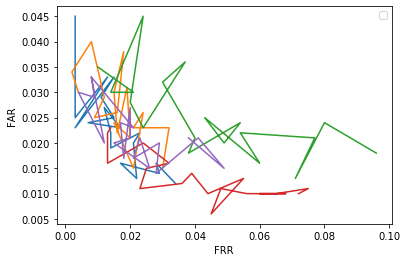

In [0]:
# Try6

#1. train subject , train subject
counter_true_false_result(0,89, 0,89)

#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

#3. new subject , new subject
counter_true_false_result(90,107, 0,89)

#4. new subject , new subject
counter_true_false_result(90,107, 90,107)

#5. all subject , all subject
counter_true_false_result(0,107, 0,107)

